In [19]:
import numpy as np
import pandas as pd
# Importing of DataFrame with the 15 features (all except of 'truth')
from correlation_matrix import x as dfNorm15, dfCorr
from newOWA_aggregation import v
from newOWA_aggregation import vTrain
from rocOWA import metrics_calc
from newOWA_aggregation import xData, yData, xDataTrain, yDataTrain, xDataTest, yDataTest
from featuresNormalization import dfNorm
import json
from sklearn.metrics import *
import matplotlib.pyplot as plt

### Defining of all singleton importance values I_i

In [2]:
def calc_importance(imporV, formula):
    I_i = np.empty([1, dfNorm15.shape[1]])
    I_i = I_i.flatten()
    for i in range(dfNorm15.shape[1]):
        I_i[i] = eval(formula)

    return I_i

### Defining of all interaction indexes I_ij

In [3]:
def calc_interaction(formula_plus, formula_minus):
    # Matrix of I_ij[i,j]
    # I_ij shape = dfNorm15.shape[1] rows and dfNorm15.shape[1] cols = 15x15 = (0,14)x(0,14)
    I_ij = np.zeros([dfNorm15.shape[1], dfNorm15.shape[1]])

    # Calculation of I_ij[i,j] values
    for i in range(dfNorm15.shape[1]):
        for j in range(dfNorm15.shape[1]):
            if i != j:
                if (dfCorr.iloc[i,j] > 0):
                    I_ij[i,j] = eval(formula_plus)
                elif (dfCorr.iloc[i,j] < 0):
                    I_ij[i, j] = eval(formula_minus)
            else:
                I_ij[i,j] = None

    # Assign the same value to the simmetric half of I[i,j]
    for i in range(I_ij.shape[0]):
        for j in range(I_ij.shape[1]):
            if j<i:
                I_ij[i, j] = I_ij[j, i]

    return I_ij

## Importance and Interaction indexes constraints satisfaction

### SUM(i=1 to n) I_i = 1

In [4]:
def sumI_i(impor_i):
    summation = 0
    for i in range(impor_i.shape[0]):
        #print(impor_i[i])
        summation += impor_i[i]

    return round(summation, 2)


### -1 <= I_ij <= 1

In [5]:
def rangeI_ij(inter_ij):
    count_no = 0
    for i in range(inter_ij.shape[0]):
        for j in range(inter_ij.shape[1]):
            if i != j:
                if inter_ij[i,j] >= -1 and inter_ij[i,j] <= 1:
                    #print(inter_ij[i,j])
                    pass
                else:
                    count_no += 1
                    print(inter_ij[i,j])
    if count_no == 0:
        #out = 'OK! All I[i,j] in range [-1,1]'
        return True
    else:
        #out = 'NOT all I[i,j] in range [-1,1]!!!'
        return False

    #return out

### Property: *I_i - 1/2 SUM |I_ij| >= 0*

In [6]:
def choquet_property(impor_i, inter_ij):
    count_no = 0
    for i in range(inter_ij.shape[0]):
        summ = 0
        for j in range(inter_ij.shape[1]):
            if i != j:
                summ += abs(inter_ij[i,j])
                #print('\n',abs(inter_ij[i,j]), '+')
        #print(i+1, summ)

        formula = (impor_i[i] - (0.5 * summ))
        #print(impor_i[i], '-0.5*', summ)
        #print(i, 'property', formula)
        if formula >= 0:
            pass
        else:
            count_no += 1

    if count_no == 0:
        #print("OK! Property satisfied")
        return True
    else:
        #print("Property NOT satisfied!!!")
        return False

    #return out

## *2-additive Choquet Integral* computation

In [7]:
def calc_choquet(f_val, impor_i, inter_ij):
    sum_interPos = 0
    sum_interNeg = 0
    for i in range(inter_ij.shape[0]):
        for j in range(inter_ij.shape[1]):
            if i != j:
                if inter_ij[i,j] > 0:
                    sum_interPos += min(f_val[i], f_val[j]) * (inter_ij[i,j])
                    #print('I[', i+1, ',', j+1, ']', inter_ij[i,j], 'fval', i+1, f_val[i], 'fval', j+1, f_val[j])
                elif inter_ij[i,j] < 0:
                    sum_interNeg += max(f_val[i], f_val[j]) * abs(inter_ij[i,j])
                    #print('I[', i + 1, ',', j + 1, ']', inter_ij[i, j], 'fval', i + 1, f_val[i], 'fval', j + 1, f_val[j])
        #print('SUM', sum_interPos)
        #print('SUM', sum_interNeg)

    last_part = 0
    for i in range(inter_ij.shape[0]):
        summ = 0
        for j in range(inter_ij.shape[1]):
            if i != j:
                summ += abs(inter_ij[i,j])
                #print('\n',abs(inter_ij[i,j]), '+')
        #print('\n', i+1, summ)

        formula = (impor_i[i] - (0.5 * summ))
        #print('vi', i+1, impor_i[i+1])
        #print('formula choq int', i, formula)
        last_part += f_val[i] * formula
        #print('last part', last_part)


    result = sum_interPos + sum_interNeg + last_part
    #print(result)
    return result

### JSON file creation with: features values, Choquet-Integral value, truth label

In [8]:
def eventsChoquet(xData, yData):
    eventsChoquet = {}
    for eventIndex in range(xData.shape[0]):
        eventsChoquet[dfNorm.index[eventIndex]] = {'features': xData[eventIndex].tolist(),
                                                   'Choquet-Integral value': calc_choquet(xData[eventIndex],
                                                                                            I_i, I_ij),
                                                   'truth': yData[eventIndex]}

    # New pandas DataFrame from the eventsOrdered to sort it by mean in descending order
    dfChoquet = pd.DataFrame(eventsChoquet)
    # Fix the orientation
    dfChoquet = dfChoquet.transpose()
    dict_dfChoquet = dfChoquet.to_dict(orient='index')
    filename = 'data/eventsChoquetIntegral.json'
    with open(filename, 'w') as file:
        output = json.dump(dict_dfChoquet, file, indent = 4)

    return dfChoquet

In [20]:
def choquet_roc_calc(label, prediction):

    fpr, tpr, thresholds = roc_curve(label, prediction)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
    #
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    #
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #
    plt.savefig("data/rocauc.pdf", format="pdf")
    plt.show()

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal ROC-AUC threshold:', round(optimal_threshold, 4))
    
    # Create a binary prediction vector based on OWA optimal threshold
    prediction_label = []
    for i in range(len(prediction)):
        if (prediction[i] >= optimal_threshold):
            prediction_label.append(1)
        else:
            prediction_label.append(0)

    accuracy = accuracy_score(label, prediction_label)
    precision = precision_score(label, prediction_label)
    recall = recall_score(label, prediction_label)
    f1 = f1_score(label, prediction_label)

    #confusion_matrix = sklearn.metrics.confusion_matrix(label, prediction_label)
    #print('\nTP:', confusion_matrix[1][1], 'TN:', confusion_matrix[0][0],
         # '\nFP:', confusion_matrix[0][1], 'FN:', confusion_matrix[1][0])

    print('\nACCURACY:', round(accuracy, 2))
    print('PRECISION:', round(precision, 2))
    print('RECALL:', round(recall, 2))
    print('F1-SCORE:', round(f1, 2), '\n')

    return round(roc_auc,2)

### I_i = V_i / sum(V_i)
### I_ij = (corr * I_i) / 15

Summation of all Importance values = 1.0
True
True 



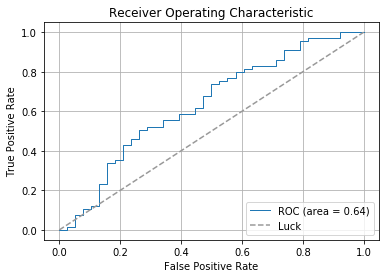

Optimal ROC-AUC threshold: 0.1388

ACCURACY: 0.59
PRECISION: 0.77
RECALL: 0.51
F1-SCORE: 0.61


In [10]:
formula = 'round(v[i]/sum(v), 3)'
I_i = calc_importance(v, formula)

formula_plus = '((dfCorr.iloc[i,j]*I_i[i])/15)'
formula_minus = '((dfCorr.iloc[i,j]*I_i[i])/15)'
I_ij = calc_interaction(formula_plus, formula_minus)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfChoquet = eventsChoquet(xDataTest, yDataTest)
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)

In [11]:
I_i

array([0.047, 0.017, 0.058, 0.119, 0.061, 0.055, 0.014, 0.05 , 0.095,
       0.072, 0.069, 0.071, 0.066, 0.079, 0.127])

In [12]:
cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#df_I_ij = df_I_ij.round(decimals=2)
df_I_ij

1         2         3         4         5         6         7   \
1        NaN -0.000815  0.001222  0.001410  0.000094 -0.000125 -0.000063   
2  -0.000815       NaN -0.000329 -0.000238 -0.000397 -0.000476 -0.000374   
3   0.001222 -0.000329       NaN  0.001392  0.000000  0.000039 -0.000116   
4   0.001410 -0.000238  0.001392       NaN  0.003491  0.003015  0.003253   
5   0.000094 -0.000397  0.000000  0.003491       NaN  0.003945  0.003985   
6  -0.000125 -0.000476  0.000039  0.003015  0.003945       NaN  0.003483   
7  -0.000063 -0.000374 -0.000116  0.003253  0.003985  0.003483       NaN   
8   0.000094 -0.000431  0.000039  0.003649  0.003945  0.003520  0.000915   
9  -0.001535  0.000181 -0.000812 -0.001190  0.000163  0.000183  0.000065   
10 -0.000783  0.000476 -0.000541 -0.000952  0.000325  0.000220  0.000056   
11 -0.000219 -0.000465 -0.000077  0.002539  0.003823  0.003557  0.000896   
12  0.001410 -0.000215  0.001469  0.003808  0.000000 -0.000220 -0.000028   
13 -0.000094 -0.000340 -0.000116  0.003173  0.003945  0.003447  0.000905   
14  0.000125 -0.000419  0.000155  0.003967  0.003945  0.003483  0.000905   
15  0.000533 -0.000453  0.000580  0.004363  0.003863  0.003300  0.000877   

          8         9         10        11        12        13        14  \
1   0.000094 -0.001535 -0.000783 -0.000219  0.001410 -0.000094  0.000125   
2  -0.000431  0.000181  0.000476 -0.000465 -0.000215 -0.000340 -0.000419   
3   0.000039 -0.000812 -0.000541 -0.000077  0.001469 -0.000116  0.000155   
4   0.003649 -0.001190 -0.000952  0.002539  0.003808  0.003173  0.003967   
5   0.003945  0.000163  0.000325  0.003823  0.000000  0.003945  0.003945   
6   0.003520  0.000183  0.000220  0.003557 -0.000220  0.003447  0.003483   
7   0.000915  0.000065  0.000056  0.000896 -0.000028  0.000905  0.000905   
8        NaN  0.000067  0.000167  0.003167  0.000000  0.003233  0.003300   
9   0.000067       NaN  0.001393  0.000570 -0.002407  0.000443  0.000000   
10  0.000167  0.001393       NaN  0.000144 -0.001344  0.000336  0.000288   
11  0.003167  0.000570  0.000144       NaN -0.000736  0.004232  0.004186   
12  0.000000 -0.002407 -0.001344 -0.000736       NaN -0.000237  0.000426   
13  0.003233  0.000443  0.000336  0.004232 -0.000237       NaN  0.004268   
14  0.003300  0.000000  0.000288  0.004186  0.000426  0.004268       NaN   
15  0.003167 -0.000190  0.000000  0.004094  0.000426  0.004048  0.004951   

          15  
1   0.000533  
2  -0.000453  
3   0.000580  
4   0.004363  
5   0.003863  
6   0.003300  
7   0.000877  
8   0.003167  
9  -0.000190  
10  0.000000  
11  0.004094  
12  0.000426  
13  0.004048  
14  0.004951  
15       NaN

### I_i = V_i / sum(V_i)
### I_ij = ((corr * I_i) / 15) + 0.02

Summation of all Importance values = 1.0
True
False 



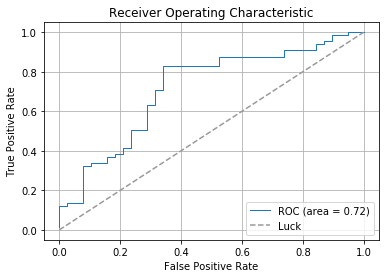

Optimal ROC-AUC threshold: 0.0179

ACCURACY: 0.77
PRECISION: 0.81
RECALL: 0.83
F1-SCORE: 0.82


In [13]:
formula = 'round(vTrain[i]/sum(vTrain), 3)'
I_i = calc_importance(vTrain, formula)

formula_plus = '((dfCorr.iloc[i,j] * I_i[i])/15)+0.02'
formula_minus = '((dfCorr.iloc[i,j] * I_i[i])/15)+0.02'
I_ij = calc_interaction(formula_plus, formula_minus)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfChoquet = eventsChoquet(xDataTest, yDataTest)
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)

In [14]:
I_i

array([0.119, 0.081, 0.04 , 0.111, 0.047, 0.075, 0.096, 0.053, 0.073,
       0.072, 0.071, 0.026, 0.074, 0.015, 0.048])

In [15]:
cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#df_I_ij = df_I_ij.round(decimals=2)
df_I_ij

1         2         3         4         5         6         7   \
1        NaN  0.017937  0.023094  0.023570  0.020238  0.019683  0.019841   
2   0.017937       NaN  0.018434  0.018866  0.018110  0.017732  0.018218   
3   0.023094  0.018434       NaN  0.020960  0.000000  0.020027  0.019920   
4   0.023570  0.018866  0.020960       NaN  0.023256  0.022812  0.023034   
5   0.020238  0.018110  0.000000  0.023256       NaN  0.023039  0.023071   
6   0.019683  0.017732  0.020027  0.022812  0.023039       NaN  0.024750   
7   0.019841  0.018218  0.019920  0.023034  0.023071  0.024750       NaN   
8   0.020238  0.017948  0.020027  0.023404  0.023039  0.024800  0.026272   
9   0.016113  0.020864  0.019440  0.018890  0.020125  0.020250  0.020448   
10  0.018017  0.022268  0.019627  0.019112  0.020251  0.020300  0.020384   
11  0.019445  0.017786  0.019947  0.022368  0.022945  0.024850  0.026144   
12  0.023570  0.018974  0.021013  0.023552  0.000000  0.019700  0.019808   
13  0.019762  0.018380  0.019920  0.022960  0.023039  0.024700  0.026208   
14  0.020317  0.018002  0.020107  0.023700  0.023039  0.024750  0.026208   
15  0.021349  0.017840  0.020400  0.024070  0.022977  0.024500  0.026016   

          8         9         10        11        12        13        14  \
1   0.020238  0.016113  0.018017  0.019445  0.023570  0.019762  0.020317   
2   0.017948  0.020864  0.022268  0.017786  0.018974  0.018380  0.018002   
3   0.020027  0.019440  0.019627  0.019947  0.021013  0.019920  0.020107   
4   0.023404  0.018890  0.019112  0.022368  0.023552  0.022960  0.023700   
5   0.023039  0.020125  0.020251  0.022945  0.000000  0.023039  0.023039   
6   0.024800  0.020250  0.020300  0.024850  0.019700  0.024700  0.024750   
7   0.026272  0.020448  0.020384  0.026144  0.019808  0.026208  0.026208   
8        NaN  0.020071  0.020177  0.023357  0.000000  0.023427  0.023498   
9   0.020071       NaN  0.021071  0.020438  0.018151  0.020341  0.000000   
10  0.020177  0.021071       NaN  0.020144  0.018656  0.020336  0.020288   
11  0.023357  0.020438  0.020144       NaN  0.019243  0.024355  0.024307   
12  0.000000  0.018151  0.018656  0.019243       NaN  0.019913  0.020156   
13  0.023427  0.020341  0.020336  0.024355  0.019913       NaN  0.024785   
14  0.023498  0.000000  0.020288  0.024307  0.020156  0.024785       NaN   
15  0.023357  0.019854  0.000000  0.024213  0.020156  0.024539  0.020940   

          15  
1   0.021349  
2   0.017840  
3   0.020400  
4   0.024070  
5   0.022977  
6   0.024500  
7   0.026016  
8   0.023357  
9   0.019854  
10  0.000000  
11  0.024213  
12  0.020156  
13  0.024539  
14  0.020940  
15       NaN

### Iterations of 0.xxx tests

In [16]:
formula = 'vTrain[i]/sum(vTrain)'
I_i = calc_importance(vTrain, formula)
#print(I_i)

# Iterations of 0.xxx
I_ij = np.zeros([dfNorm15.shape[1], dfNorm15.shape[1]])

In [17]:
# Initialization of I_ij[i,j] values with dfCorr[i,j] values
for i in range(dfNorm15.shape[1]):
    for j in range(dfNorm15.shape[1]):
        if i != j:
            if (dfCorr.iloc[i,j] > 0):
                I_ij[i,j] = 0
            elif (dfCorr.iloc[i,j] < 0):
                I_ij[i,j] = 0
        else:
            I_ij[i,j] = None
# Assign the same value to the simmetric half of I[i,j]
for i in range(I_ij.shape[0]):
    for j in range(I_ij.shape[1]):
        if j<i:
            I_ij[i, j] = I_ij[j, i]

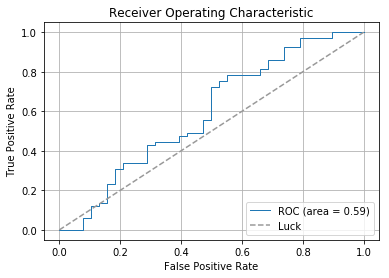

Optimal ROC-AUC threshold: 0.1341

ACCURACY: 0.66
PRECISION: 0.71
RECALL: 0.78
F1-SCORE: 0.74 

ROC: 0.59 



In [21]:
if choquet_property(I_i, I_ij) and rangeI_ij(I_ij):
    dfChoquet = eventsChoquet(xDataTest, yDataTest)
    label = dfChoquet['truth'].values.astype(float)
    predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
    rangeI_ij(I_ij)
    #print(choquet_property(I_i, I_ij))
    print('ROC:', choquet_roc_calc(label, predictionChoquet), '\n')
    #print(I_ij)

In [19]:
const = 0.0001

In [24]:
def iteration_Iij():
    for i in range(I_ij.shape[0]):
        for j in range(I_ij.shape[1]):
            if  I_ij[i,j] >= 1:
                continue
            elif I_ij[i,j] <= -1:
                continue
            else:
                if i != j:
                    if (dfCorr.iloc[i,j] >= 0):
                        I_ij[i,j] += const
                    elif (dfCorr.iloc[i,j] < 0):
                        I_ij[i,j] -= const
                else:
                    I_ij[i,j] = None
    # Assign the same value to the simmetric half of I[i,j]
    for i in range(I_ij.shape[0]):
        for j in range(I_ij.shape[1]):
            if j<i:
                I_ij[i, j] = I_ij[j, i]

    if choquet_property(I_i, I_ij): # and rangeI_ij(I_ij):
        dfChoquet = eventsChoquet(xDataTest, yDataTest)
        label = dfChoquet['truth'].values.astype(float)
        predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
        rangeI_ij(I_ij)
        #print(choquet_property(I_i, I_ij))
        print('iteration number:', iteration)
        print('ROC:', choquet_roc_calc(label, predictionChoquet), '\n')
    #print(I_ij)

In [25]:
count = 1/const
iteration = 0
while (count > 0):
    iteration_Iij()
    count -= 1
    iteration += 1
    #print(I_ij, '\n')
#print(I_ij)

### Most important 8 features with I_i - I_ij from R Kappalab LS (Least Squares)

Summation of all Importance values = 1.0
True
True 



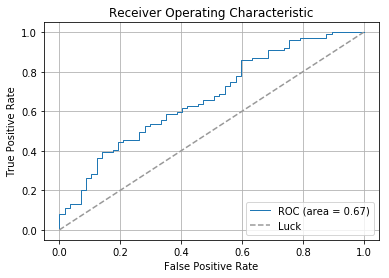

Optimal ROC-AUC threshold: 0.2365

ACCURACY: 0.69
PRECISION: 0.71
RECALL: 0.86
F1-SCORE: 0.78


In [23]:
shapleyR = np.empty([1, dfNorm15.shape[1]])
shapleyR = shapleyR.flatten()
#Least Squares (ls)
shapleyR[0]= 0.47207845; shapleyR[1]= 0.07011420; shapleyR[2]= 0.07008788; shapleyR[3]= 0.07526805
shapleyR[4]= 0.09159382; shapleyR[5]= 0.07514807; shapleyR[6]= 0.07565047; shapleyR[7]= 0.07005906
shapleyR[8]= 0; shapleyR[9]= 0; shapleyR[10]= 0; shapleyR[11]= 0; shapleyR[12]= 0; shapleyR[13]= 0; shapleyR[14]= 0
formula = 'shapleyR[i]'
I_i = calc_importance(shapleyR, formula)
#print(I_i)

I_ij = np.genfromtxt("/Users/marcodegra/Documents/thesis_repo/fake_news_repos/R/8ls_inter_indicesR.csv", delimiter = ",")
#cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#print(df_I_ij)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfNorm = dfNorm[["verified", "friends", "objectivity", "urlCount", "status_count", "polarity", "retweetCount",
                         "tweetCount", "hashtagCount", "followers", "lifespan", "mentionCount", "ages", "density",
                         "mediaCount", "truth"]]
x = dfNorm[list(filter(lambda x: x != "truth", dfNorm.columns))]
y = dfNorm["truth"]
xData = x.as_matrix()
yData = y.as_matrix()

dfChoquet = eventsChoquet()
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)


### Kappalab C4e8f ls

Summation of all Importance values = 1.0
True
True 



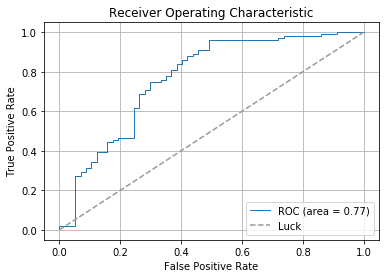

Optimal ROC-AUC threshold: 0.0733

ACCURACY: 0.79
PRECISION: 0.77
RECALL: 0.96
F1-SCORE: 0.86


In [24]:
shapleyR = np.empty([1, dfNorm15.shape[1]])
shapleyR = shapleyR.flatten()
#Least Squares (ls)
shapleyR[0]= 0.473106763; shapleyR[1]= 0.005099635; shapleyR[2]= 0.006520065; shapleyR[3]= 0.004937881
shapleyR[4]= 0.004988512; shapleyR[5]= 0.026507986; shapleyR[6]= 0.473747349; shapleyR[7]= 0.005091809
shapleyR[8]= 0; shapleyR[9]= 0; shapleyR[10]= 0; shapleyR[11]= 0; shapleyR[12]= 0; shapleyR[13]= 0; shapleyR[14]= 0
formula = 'shapleyR[i]'
I_i = calc_importance(shapleyR, formula)
#print(I_i)

I_ij = np.genfromtxt("/Users/marcodegra/Documents/thesis_repo/fake_news_repos/R/training_set/ls4e8f_inter_indicesR.csv", delimiter = ",")
#cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#print(df_I_ij)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfNorm = dfNorm[["verified", "friends", "objectivity", "urlCount", "status_count", "polarity", "retweetCount",
                         "tweetCount", "hashtagCount", "followers", "lifespan", "mentionCount", "ages", "density",
                         "mediaCount", "truth"]]
x = dfNorm[list(filter(lambda x: x != "truth", dfNorm.columns))]
y = dfNorm["truth"]
xData = x.as_matrix()
yData = y.as_matrix()

dfChoquet = eventsChoquet()
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)


In [25]:
pd.options.display.float_format = '{:.4f}'.format
cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#df_I_ij = df_I_ij.round(decimals=2)
df_I_ij

1       2       3       4       5       6       7       8      9   \
1      nan -0.0000 -0.0004 -0.0000 -0.0000 -0.0034 -0.9424 -0.0000 0.0000   
2  -0.0000     nan -0.0011 -0.0000 -0.0000 -0.0091 -0.0000 -0.0000 0.0000   
3  -0.0004 -0.0011     nan -0.0010 -0.0011  0.0074 -0.0006 -0.0011 0.0000   
4  -0.0000 -0.0000 -0.0010     nan -0.0000 -0.0088 -0.0000 -0.0000 0.0000   
5  -0.0000 -0.0000 -0.0011 -0.0000     nan -0.0089 -0.0000 -0.0000 0.0000   
6  -0.0034 -0.0091  0.0074 -0.0088 -0.0089     nan -0.0045 -0.0091 0.0000   
7  -0.9424 -0.0000 -0.0006 -0.0000 -0.0000 -0.0045     nan -0.0000 0.0000   
8  -0.0000 -0.0000 -0.0011 -0.0000 -0.0000 -0.0091 -0.0000     nan 0.0000   
9   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    nan   
10  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
11  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
12  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
13  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
14  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
15  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   

       10     11     12     13     14     15  
1  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
2  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
3  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
4  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
5  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
6  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
7  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
8  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
9  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
10    nan 0.0000 0.0000 0.0000 0.0000 0.0000  
11 0.0000    nan 0.0000 0.0000 0.0000 0.0000  
12 0.0000 0.0000    nan 0.0000 0.0000 0.0000  
13 0.0000 0.0000 0.0000    nan 0.0000 0.0000  
14 0.0000 0.0000 0.0000 0.0000    nan 0.0000  
15 0.0000 0.0000 0.0000 0.0000 0.0000    nan

### *prove*

Summation of all Importance values = 1.0
True
True 



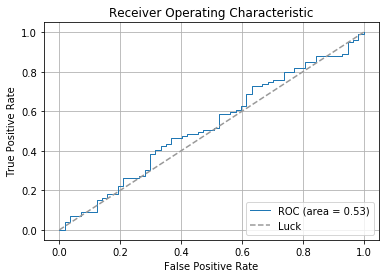

Optimal ROC-AUC threshold: 0.8603

ACCURACY: 0.53
PRECISION: 0.69
RECALL: 0.46
F1-SCORE: 0.55


In [26]:
shapleyR = np.empty([1, dfNorm15.shape[1]])
shapleyR = shapleyR.flatten()
#Least Squares (ls)

shapleyR[0]= 0.000001514976; shapleyR[1]= 0.000001002512; shapleyR[2]= 0.493016881017; shapleyR[3]= 0.006980581795
shapleyR[4]= 0.000001002173; shapleyR[5]= 0.499996994644; shapleyR[6]= 0.000001011344; shapleyR[7]= 0.000001011539
shapleyR[8]= 0; shapleyR[9]= 0; shapleyR[10]= 0; shapleyR[11]= 0; shapleyR[12]= 0; shapleyR[13]= 0; shapleyR[14]= 0
formula = 'shapleyR[i]'
I_i = calc_importance(shapleyR, formula)
#print(I_i)

I_ij = np.genfromtxt("/Users/marcodegra/Documents/thesis_repo/fake_news_repos/R/training_set/ls156e8f_inter_indicesR.csv", delimiter = ",")
#cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#print(df_I_ij)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfNorm = dfNorm[["verified", "friends", "objectivity", "urlCount", "status_count", "polarity", "retweetCount",
                         "tweetCount", "hashtagCount", "followers", "lifespan", "mentionCount", "ages", "density",
                         "mediaCount", "truth"]]
x = dfNorm[list(filter(lambda x: x != "truth", dfNorm.columns))]
y = dfNorm["truth"]
xData = x.as_matrix()
yData = y.as_matrix()

dfChoquet = eventsChoquet()
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)


### Most important 7 features (TRAINING SET) with I_i - I_ij from R Kappalab LS (Least Squares)

Summation of all Importance values = 1.0
True
True 



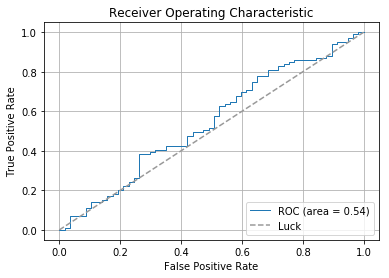

Optimal ROC-AUC threshold: 0.6685

ACCURACY: 0.62
PRECISION: 0.68
RECALL: 0.78
F1-SCORE: 0.72


In [27]:
shapleyR = np.empty([1, dfNorm15.shape[1]])
shapleyR = shapleyR.flatten()
#Least Squares (ls) 7 FEATURES, TRAINING SET
shapleyR[0]= 0.000001013671; shapleyR[1]= 0.050973901672; shapleyR[2]= 0.268166487664; shapleyR[3]= 0.180859089637
shapleyR[4]= 0.000001004578; shapleyR[5]= 0.499997489923; shapleyR[6]= 0.000001012856; shapleyR[7]= 0
shapleyR[8]= 0; shapleyR[9]= 0; shapleyR[10]= 0; shapleyR[11]= 0; shapleyR[12]= 0; shapleyR[13]= 0; shapleyR[14]= 0
formula = 'shapleyR[i]'
I_i = calc_importance(shapleyR, formula)
#print(I_i)

I_ij = np.genfromtxt("/Users/marcodegra/Documents/thesis_repo/fake_news_repos/R/training_set/7lsTrain_inter_indicesR.csv", delimiter = ",")
#cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#df_I_ij = pd.DataFrame(I_ij, columns=cols, index=cols)
#print(df_I_ij)

print('Summation of all Importance values =', sumI_i(I_i))
print(rangeI_ij(I_ij))
print(choquet_property(I_i, I_ij), '\n')

dfNorm = dfNorm[["verified", "friends", "objectivity", "urlCount", "status_count", "polarity", "retweetCount",
                         "tweetCount", "hashtagCount", "followers", "lifespan", "mentionCount", "ages", "density",
                         "mediaCount", "truth"]]
x = dfNorm[list(filter(lambda x: x != "truth", dfNorm.columns))]
y = dfNorm["truth"]
xData = x.as_matrix()
yData = y.as_matrix()

dfChoquet = eventsChoquet()
label = dfChoquet['truth'].values.astype(float)
predictionChoquet = dfChoquet['Choquet-Integral value'].values.astype(float)
metrics_calc(label, predictionChoquet)
